In [1]:

#GEM MIXTURE GENERATOR
%tensorflow_version 1.x

!nvcc --version
!nvidia-smi

import numpy as np 
import os
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
import matplotlib.pyplot as plt
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive
 



TensorFlow 1.x selected.
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



Using TensorFlow backend.


# Set Up Drive and Get Data

In [2]:
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
 %cd "/content/gdrive/My Drive"

/content/gdrive/My Drive


In [0]:
def getData(pathd,shape):
    #file i/o çalışılmalı
    Alldatas=[]
    img_data=[]
    img_data=os.listdir(pathd)
    for image in img_data:
        _,extension = os.path.splitext(image)
        if(extension==".jpg" or extension==".jpeg" or extension==".png"):
            img=load_img(pathd+"/"+image)
            img=img.resize((shape[0],shape[1]))
            x=img_to_array(img)
            # x=x.reshape((1,) + x.shape)
            Alldatas.append(x)
    return Alldatas

# Set Up Parameters

In [0]:
featureSize=15
SCALE=30 #RESIZE ALL IMAGES TO 30X30
checkpoint = ModelCheckpoint( "gemmodelv2.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
LRchange = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=30,
    verbose=1,
    mode='min',
     cooldown=0,
    min_lr=0.0001)
callbacklists=[checkpoint,LRchange]

# Gettings images (at least 400x400 pixel images or all images) for training and testing

In [0]:
curr_path = "ALL400x400"


all_img_test = getData(curr_path + "/Test"  ,(SCALE,SCALE))
print("Test images loaded")
all_img      = getData(curr_path + "/Train" ,(SCALE,SCALE))
print("Train images loaded")

#%%





KeyboardInterrupt: ignored

In [11]:
 
all_img_test = getData( "DataSets/GEM/ALLTEST"  ,(SCALE,SCALE))
print("Test images loaded")
all_img      = getData( "DataSets/GEM/ALL" ,(SCALE,SCALE))
print("Train images loaded")

#%%





KeyboardInterrupt: ignored

Reshape and Normalize Train and Test Set

In [0]:
# EDIT DATASET AND RESHAPE
all_img=np.asarray(all_img,dtype="float")
all_img_test=np.asarray(all_img_test,dtype="float")

train=all_img/255 
test=all_img_test/255 

trainCount=train.shape[0]
testCount=test.shape[0]

train,test=train.flatten(),test.flatten()
trainShape=int(train.shape[0]/trainCount)
testShape=int(test.shape[0]/testCount)

train,test=train.reshape(trainCount,trainShape),test.reshape(testCount,testShape)
#%%

# Setting Up AutoEncoder model

From scratch

In [0]:
#CREATE AUTOENCODER

from keras.layers import Activation
from keras import optimizers
def cust(x):
    return tf.keras.backend.sigmoid(x) 


model = Sequential()

opt = optimizers.adamax(learning_rate=0.001)
model.add(Dense(input_dim=train.shape[1],output_dim=train.shape[1],init='uniform'))
model.add(Dense(256, kernel_initializer='lecun_normal'))

model.add(Dense(featureSize, kernel_initializer='uniform',activation="sigmoid")) #SIGMOID TO EASILY GENERATE IMAGES IN WIDE RANGE

model.add(Dense(256, kernel_initializer='lecun_normal'))
model.add(Dense(train.shape[1],init='uniform',activation="sigmoid"))

print(model.summary())
model.compile(loss="mean_squared_error",optimizer=opt)
 
    



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 2700)              7292700   
_________________________________________________________________
dense_12 (Dense)             (None, 256)               691456    
_________________________________________________________________
dense_13 (Dense)             (None, 40)                10280     
_________________________________________________________________
dense_14 (Dense)             (None, 256)               10496     
_________________________________________________________________
dense_15 (Dense)             (None, 2700)              693900    
Total params: 8,698,832
Trainable params: 8,698,832
Non-trainable params: 0
_________________________________________________________________
None


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=2700, units=2700, kernel_initializer="uniform")`
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2700, activation="sigmoid", kernel_initializer="uniform")`


Or Continue from saved model

In [0]:
from keras.models import load_model, save_model

model = load_model("gemmodelv2.h5")


Instructions for updating:
If using Keras pass *_constraint arguments to layers.



Train

In [0]:
model.fit(train,
          train,
          epochs = 10000,
          batch_size = 32,
          validation_data = (test,test),
         # callbacks=callbacklists, #SET ACTIVE IF YOU WANT TO SAVE WEIGHTS
          verbose=1 ,use_multiprocessing=True,callbacks=callbacklists)

Streaming output truncated to the last 5000 lines.

Epoch 01033: val_loss did not improve from 0.01317
Epoch 1034/10000
2800/2800 [==============================] - 9s 3ms/step - loss: 0.0111 - val_loss: 0.0132

Epoch 01034: val_loss did not improve from 0.01317
Epoch 1035/10000
2800/2800 [==============================] - 9s 3ms/step - loss: 0.0111 - val_loss: 0.0134

Epoch 01035: val_loss did not improve from 0.01317
Epoch 1036/10000
2800/2800 [==============================] - 9s 3ms/step - loss: 0.0111 - val_loss: 0.0132

Epoch 01036: val_loss did not improve from 0.01317
Epoch 1037/10000
2800/2800 [==============================] - 9s 3ms/step - loss: 0.0111 - val_loss: 0.0132

Epoch 01037: val_loss did not improve from 0.01317
Epoch 1038/10000
2800/2800 [==============================] - 9s 3ms/step - loss: 0.0111 - val_loss: 0.0134

Epoch 01038: val_loss did not improve from 0.01317
Epoch 1039/10000
2800/2800 [==============================] - 9s 3ms/step - loss: 0.0111 - val_lo

KeyboardInterrupt: ignored

# Testing

Get Model

In [6]:
from keras.models import load_model, save_model

model = load_model("gemmodelv2.h5")


Instructions for updating:
If using Keras pass *_constraint arguments to layers.



Getting test Images

In [12]:
all_img_test = getData( "DataSets/GEM/ALLTEST"  ,(SCALE,SCALE))
# EDIT DATASET AND RESHAPE
all_img_test=np.asarray(all_img_test,dtype="float")

  
test=all_img_test/255 

 
testCount=test.shape[0]

test= test.flatten()
 
testShape=int(test.shape[0]/testCount)

test= test.reshape(testCount,testShape)
 
print("Test images loaded")

Test images loaded


Evaluate and see loss

In [15]:
results = model.evaluate(test, test, batch_size=1,verbose=1)
results

364/364 [==============================] - 2s 4ms/step


0.013173476548527706

Compare on test image

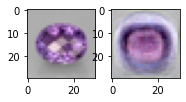

In [16]:
#%% Check difference between test images
import cv2
check=test[9]
decoded=model.predict(check.reshape((1,)+check.shape))
decoded=(decoded )
matrix=decoded.reshape(SCALE,SCALE,3)

#Show real image and compressed image from autoencoder
plt.figure(figsize=(30,30))
plt.subplot(20,20,1)
plt.imshow(array_to_img(((check )).reshape(SCALE,SCALE,3)))
plt.subplot(20,20,2)
filterr = np.array([[-1, -1, -1], [-1, 10, -1], [-1, -1, -1]])
matrix= cv2.filter2D(matrix, -1, filterr)
Gimage=array_to_img(matrix )
plt.imshow(Gimage)



# Generating New Images

Getting Decoder from AutoEncoder Model

In [18]:
#%% Get generator model FROM AUTOENCODER
from keras.models import Model
from keras.engine.input_layer import Input 

GEM_input=Input(shape=(featureSize,))
GEM_model=GEM_input

for layer in model.layers[3:]:
     
    GEM_model= layer(GEM_model)
GEM_model = Model(inputs=GEM_input, outputs=GEM_model)
print(GEM_model.summary())
#%% SET SEED FOR RANDOM NUMBER GENERATOR

np.random.seed(seed=42)
 

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 15)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 256)               4096      
_________________________________________________________________
dense_40 (Dense)             (None, 2700)              693900    
Total params: 697,996
Trainable params: 697,996
Non-trainable params: 0
_________________________________________________________________
None


Generating New Images

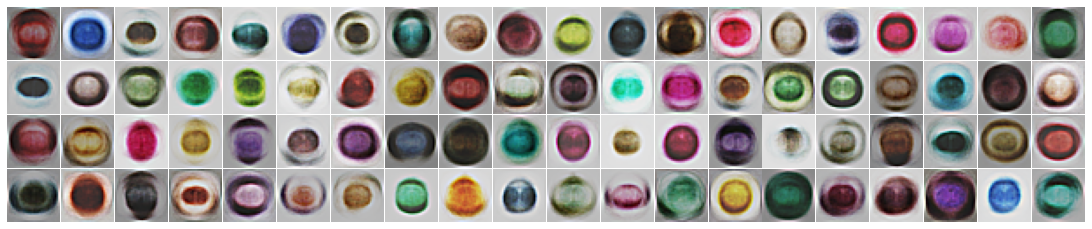

In [19]:
#%% Generate and show new images
import scipy
from scipy import ndimage
import cv2
plt.figure(figsize=(15,15))
matrix = []
for i in range(0,80):
    plt.subplot(20,20,i+1)
    random_features=np.random.uniform(0,1,featureSize) # GENERATE RANDOM NUMBERS BETWEEN 0 AND 1 BECAUSE WE USED SIGMOID
    random_features = random_features.reshape( (1,featureSize))
     
     
    new_Img=GEM_model.predict(random_features)
     
    matrix.append( new_Img.reshape(SCALE,SCALE,3))
     
    filterr = np.array([[-1, -1, -1], [-1, 10, -1], [-1, -1, -1]])
    mx= cv2.filter2D(matrix[i], -1, filterr)
     
     
    Gimage=array_to_img(mx )

    
    plt.imshow(Gimage)
    plt.axis("off")
plt.tight_layout(pad=0.1)

